In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
# from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats
from scipy import signal as sg
from s3fs import S3FileSystem, S3Map
import scipy
from scipy import stats
from scipy.special import kv as K_nu
from scipy.special import gamma
from scipy.optimize import minimize
# mle function import
from IPython.display import display, HTML
import importlib
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [25, 10]
#np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['animation.embed_limit'] = 2**128

# Import raw observation data and PSD processing

The raw observation data is extracted from IMOS open access ocean data at Australia NWS 400km offshore

In [6]:
# Login to the s3 bucket and list the deep water mooring (DWM) folders
fs = S3FileSystem(anon=True)
aodn = fs.ls('imos-data/IMOS/DWM/')
for item in aodn:
    print(item)

imos-data/IMOS/DWM/ASFS
imos-data/IMOS/DWM/DA
imos-data/IMOS/DWM/Deployments
imos-data/IMOS/DWM/SOTS


In [7]:
## Australia NWS
ITFTIS_vel_ncfiles= ['imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20120110T235900Z_ITFTIS_FV01_ITFTIS-1201-Long-Ranger-Workhorse-ADCP-453_END-20120722T045900Z_C-20180111T081951Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20120722T005900Z_ITFTIS_FV01_ITFTIS-1207-Long-Ranger-Workhorse-ADCP-452_END-20121213T225900Z_C-20180117T055124Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20121213T045900Z_ITFTIS_FV01_ITFTIS-1212-Long-Ranger-Workhorse-ADCP-451_END-20130621T073900Z_C-20180122T003930Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20140110T005900Z_ITFTIS_FV01_ITFTIS-1401-Long-Ranger-Workhorse-ADCP-453.5_END-20140909T023900Z_C-20180516T064308Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20140908T102900Z_ITFTIS_FV01_ITFTIS-1409-Long-Ranger-Workhorse-ADCP-450.5_END-20150207T034900Z_C-20180516T032033Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20150206T055900Z_ITFTIS_FV01_ITFTIS-1502-Long-Ranger-Workhorse-ADCP-456.4_END-20150810T033900Z_C-20180515T071600Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20150807T095900Z_ITFTIS_FV01_ITFTIS-1508-Long-Ranger-Workhorse-ADCP-461.5_END-20160208T233900Z_C-20180509T034743Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20160208T045900Z_ITFTIS_FV01_ITFTIS-1602-Long-Ranger-Workhorse-ADCP-452.8_END-20160731T061900Z_C-20180502T044947Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20160729T035900Z_ITFTIS_FV01_ITFTIS-1607-Long-Ranger-Workhorse-ADCP-452.5_END-20170212T221900Z_C-20180502T023613Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20170207T075900Z_ITFTIS_FV01_ITFTIS-1702-Long-Ranger-Workhorse-ADCP-454.6_END-20170720T081900Z_C-20180430T014529Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20170719T055900Z_ITFTIS_FV01_ITFTIS-1707-Long-Ranger-Workhorse-ADCP-453_END-20180213T105900Z_C-20180227T061344Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20180212T055900Z_ITFTIS_FV01_ITFTIS-1802-Long-Ranger-Workhorse-ADCP-457.4_END-20180804T013900Z_C-20181102T025044Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20180803T045900Z_ITFTIS_FV01_ITFTIS-1807-Long-Ranger-Workhorse-ADCP-452.9_END-20190127T101859Z_C-20190401T041149Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20100630T015900Z_ITFTIS_FV01_ITFTIS-1006-Long-Ranger-Workhorse-ADCP-456.8_END-20110107T015859Z_C-20171113T024440Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20110107T055900Z_ITFTIS_FV01_ITFTIS-1101-Long-Ranger-Workhorse-ADCP-458_END-20110528T003859Z_C-20171109T035545Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20110529T125900Z_ITFTIS_FV01_ITFTIS-1105-Long-Ranger-Workhorse-ADCP-453.7_END-20120110T101859Z_C-20171113T072535Z.nc',
'imos-data/IMOS/ANMN/QLD/ITFTIS/Velocity/IMOS_ANMN-QLD_AETVZ_20130620T075900Z_ITFTIS_FV01_ITFTIS-1306-Long-Ranger-Workhorse-ADCP-455.5_END-20140111T055900Z_C-20160607T064033Z.nc',]

In [8]:
## Australia NWS
KIM400_vel_ncfiles = ['imos-data/IMOS/ANMN/QLD/KIM400/Velocity/IMOS_ANMN-QLD_AETVZ_20120203T011900Z_KIM400_FV01_KIM400-1202-Long-Ranger-Workhorse-ADCP-389_END-20120809T015900Z_C-20171204T063611Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Velocity/IMOS_ANMN-QLD_AETVZ_20120810T215900Z_KIM400_FV01_KIM400-1208-Long-Ranger-Workhorse-ADCP-388_END-20130127T081859Z_C-20171205T063309Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Velocity/IMOS_ANMN-QLD_AETVZ_20130126T115900Z_KIM400_FV01_KIM400-1301-Long-Ranger-Workhorse-ADCP-388_END-20130723T071900Z_C-20171205T080624Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Velocity/IMOS_ANMN-QLD_AETVZ_20130724T235900Z_KIM400_FV01_KIM400-1307-Long-Ranger-Workhorse-ADCP-384_END-20140131T123900Z_C-20171205T092413Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Velocity/IMOS_ANMN-QLD_AETVZ_20140131T015900Z_KIM400_FV01_KIM400-1401-Long-Ranger-Workhorse-ADCP-388.4_END-20140824T051900Z_C-20171211T020553Z.nc',
]

In [9]:
## Australia NWS
PIL200_vel_ncfiles = ['imos-data/IMOS/ANMN/QLD/PIL200/Velocity/IMOS_ANMN-QLD_AETVZ_20120219T235901Z_PIL200_FV01_PIL200-1202-Quartermaster-Workhorse-ADCP-191.5_END-20120819T002901Z_C-20170620T005838Z.nc',
'imos-data/IMOS/ANMN/QLD/PIL200/Velocity/IMOS_ANMN-QLD_AETVZ_20120817T095900Z_PIL200_FV01_PIL200-1208-Long-Ranger-Workhorse-ADCP-194_END-20130202T001900Z_C-20170620T084752Z.nc',
'imos-data/IMOS/ANMN/QLD/PIL200/Velocity/IMOS_ANMN-QLD_AETVZ_20130204T115900Z_PIL200_FV01_PIL200-1301-Long-Ranger-Workhorse-ADCP-198_END-20130731T050400Z_C-20170620T012050Z.nc',
'imos-data/IMOS/ANMN/QLD/PIL200/Velocity/IMOS_ANMN-QLD_AETVZ_20130802T055900Z_PIL200_FV01_PIL200-1307-Long-Ranger-Workhorse-ADCP-196.8_END-20140209T021400Z_C-20170620T013818Z.nc',
'imos-data/IMOS/ANMN/QLD/PIL200/Velocity/IMOS_ANMN-QLD_AETVZ_20140210T235900Z_PIL200_FV01_PIL200-1402-Long-Ranger-Workhorse-ADCP-198.8_END-20140817T002900Z_C-20170620T020110Z.nc',
]

In [10]:
## Australia NWS
KIM200_vel_ncfiles = [
'imos-data/IMOS/ANMN/QLD/KIM200/Velocity/IMOS_ANMN-QLD_AETVZ_20120201T093900Z_KIM200_FV01_KIM200-1202-Quartermaster-Workhorse-ADCP-194.5_END-20120809T031900Z_C-20171201T052314Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM200/Velocity/IMOS_ANMN-QLD_AETVZ_20120811T005900Z_KIM200_FV01_KIM200-1208-Quartermaster-Workhorse-ADCP-195_END-20130125T035716Z_C-20171201T064223Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM200/Velocity/IMOS_ANMN-QLD_AETVZ_20130126T115900Z_KIM200_FV01_KIM200-1301-Quartermaster-Workhorse-ADCP-201_END-20130723T100859Z_C-20171204T015841Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM200/Velocity/IMOS_ANMN-QLD_AETVZ_20130724T235900Z_KIM200_FV01_KIM200-1307-Quartermaster-Workhorse-ADCP-200.3_END-20130731T020900Z_C-20171204T034236Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM200/Velocity/IMOS_ANMN-QLD_AETVZ_20140130T235900Z_KIM200_FV01_KIM200-1401-Quartermaster-Workhorse-ADCP-200_END-20140827T041859Z_C-20171204T044049Z.nc',
]

In [28]:
from functions import Processing
example_ds = Processing.Open_file_nocache(KIM200_vel_ncfiles[0], fs)
example_ds

C:\Users\21924032\Anaconda3\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 98MB
Dimensions:                   (TIME: 27323, HEIGHT_ABOVE_SENSOR: 20)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 219kB 2012-02-01T09:39:00...
  * HEIGHT_ABOVE_SENSOR       (HEIGHT_ABOVE_SENSOR) float32 80B 14.24 ... 204.2
    LATITUDE                  float64 8B ...
    LONGITUDE                 float64 8B ...
    NOMINAL_DEPTH             float32 4B ...
Data variables: (12/59)
    TIMESERIES                int32 4B ...
    VCUR                      (TIME, HEIGHT_ABOVE_SENSOR) float32 2MB ...
    VCUR_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 2MB ...
    UCUR                      (TIME, HEIGHT_ABOVE_SENSOR) float32 2MB ...
    UCUR_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 2MB ...
    WCUR                      (TIME, HEIGHT_ABOVE_SENSOR) float32 2MB ...
    ...                        ...
    ABSI2                     (TIME, HEIGHT_ABOVE_SENSOR) float32 2MB ...
    ABSI2_quality_control     (TIME, HEIGHT_ABOVE_SENSOR) float32 2MB ...
    ABSI3                     (TIME, HEIGHT_ABOVE_SENSOR) float32 2MB ...
    ABSI3_quality_control     (TIME, HEIGHT_ABOVE_SENSOR) float32 2MB ...
    ABSI4                     (TIME, HEIGHT_ABOVE_SENSOR) float32 2MB ...
    ABSI4_quality_control     (TIME, HEIGHT_ABOVE_SENSOR) float32 2MB ...
Attributes: (12/61)
    abstract:                         The Queensland and Northern Australia m...
    acknowledgement:                  Any users of IMOS data are required to ...
    author:                           Australian Institute of Marine Science
    author_email:                     adc@aims.gov.au
    cdm_data_type:                    Station
    citation:                         The citation in a list of references is...
    ...                               ...
    toolbox_input_file:               /export/imos/Processed/KIM/KIM200/KIM20...
    toolbox_version:                  2.5.36 - GLNXA64
    compliance_checks_passed:         cf imos:1.4
    compliance_checker_version:       2.3.1
    compliance_checker_imos_version:  1.1.3
    history:                          2017-12-01T05:30:31Z - depthPP: Depth c...

In [30]:
# Calculate the Coriolis frequency
lat = example_ds.LATITUDE.values
lon = example_ds.LONGITUDE.values
f_coriolis = 4*np.pi/86400 * np.sin(lat*np.pi/180)
f_coriolis_cpd = np.abs(f_coriolis*86400/(2*np.pi))
print('Coriolis frequency is',f_coriolis_cpd, 'cpd')
print(lat,lon)
#Principal lunar semidiurnal
M2_freq = 0.0805*24 #cpd
M4_freq = 2*M2_freq
#Lunar elliptic semidiurnal
N2_freq = 0.0790*24 #cpd

#Princinpal lunar diurnal
O1_freq = 0.0387*24 #cpd

#Lunisolar diurnal
K1_freq = 0.0418*24 #cpd

#Principal solar semidiurnal
S2_freq = 0.0833*24 #cpd

xcoords = [f_coriolis_cpd,  K1_freq,O1_freq,M2_freq,S2_freq]
xcoords_label = ['Coriolis_freq', 'K1', 'O1','M2','S2']
xcoords_color = ['orange', 'c', 'm','r','b','g']

Coriolis frequency is 0.535641057028318 cpd
-15.5346166667 121.2431333333


## Grid and Windowing the temp data 

In [33]:
def Extract_good_data(raw_data, badidx):
    # Convert to numpy arrays if not already
    badidx = np.asarray(badidx)
    # Find the first and last False indices (good data boundary)
    first_good_idx = np.argmax(~badidx)  # First False (good data) index
    last_good_idx = len(badidx) - np.argmax(~badidx[::-1]) - 1  # Last False index
    # Extract good data between the boundaries
    good_data = raw_data[first_good_idx:last_good_idx + 1]
    return good_data

In [35]:
def Collect_vel(ncfiles,varname,interested_depth):
    vel_data_list = []
    fs = S3FileSystem(anon=True)
    for files in ncfiles:
        data = Processing.Open_file_nocache(files,fs) 
        vel_raw,vel_badidx_raw = Processing.get_temp_qc_aodn(data, varname=varname)
        #choose a depth surface 
        depth_idx = np.argmin(np.abs(data.NOMINAL_DEPTH - data.HEIGHT_ABOVE_SENSOR -50).values)
        vel_clean = Extract_good_data(vel_raw[:,depth_idx],vel_badidx_raw[:,depth_idx])
        vel_clean = vel_clean.interpolate_na(dim="TIME", method="linear")
        #remove mean
        vel_data_list.append(vel_clean-vel_clean.mean())
    return vel_data_list

In [37]:
interested_depth = 50 #m
KIM200_Vel_V_Dataset_list = Collect_vel(KIM200_vel_ncfiles,'VCUR',interested_depth)
KIM200_Vel_U_Dataset_list = Collect_vel(KIM200_vel_ncfiles,'UCUR',interested_depth)
KIM400_Vel_V_Dataset_list = Collect_vel(KIM400_vel_ncfiles,'VCUR',interested_depth)
KIM400_Vel_U_Dataset_list = Collect_vel(KIM400_vel_ncfiles,'UCUR',interested_depth)
PIL200_Vel_V_Dataset_list = Collect_vel(PIL200_vel_ncfiles,'VCUR',interested_depth)
PIL200_Vel_U_Dataset_list = Collect_vel(PIL200_vel_ncfiles,'UCUR',interested_depth)
ITFTIS_Vel_V_Dataset_list = Collect_vel(ITFTIS_vel_ncfiles,'VCUR',interested_depth)
ITFTIS_Vel_U_Dataset_list = Collect_vel(ITFTIS_vel_ncfiles,'UCUR',interested_depth)

In [38]:
def Read_data(Dataset_list,site_name):
    ds_dict = {}
    ds_time_dict = {}
    for order1,ds in enumerate(Dataset_list):
        #remove mean
        ds_name = "{}_P{}".format(site_name,order1)
        ds_dict[ds_name]      = ds
        ds_time_dict[ds_name] = ds['TIME'].values
            
    return ds_dict,ds_time_dict

In [39]:
KIM200_Vel_V_dict,KIM200_Time_dict = Read_data(KIM200_Vel_V_Dataset_list,'KIM200')
KIM200_Vel_U_dict,KIM200_Time_dict = Read_data(KIM200_Vel_U_Dataset_list,'KIM200')
KIM400_Vel_V_dict,KIM400_Time_dict = Read_data(KIM400_Vel_V_Dataset_list,'KIM400')
KIM400_Vel_U_dict,KIM400_Time_dict = Read_data(KIM400_Vel_U_Dataset_list,'KIM400')
PIL200_Vel_V_dict,PIL200_Time_dict = Read_data(PIL200_Vel_V_Dataset_list,'PIL200')
PIL200_Vel_U_dict,PIL200_Time_dict = Read_data(PIL200_Vel_U_Dataset_list,'PIL200')
ITFTIS_Vel_V_dict,ITFTIS_Time_dict = Read_data(ITFTIS_Vel_V_Dataset_list,'ITFTIS')
ITFTIS_Vel_U_dict,ITFTIS_Time_dict = Read_data(ITFTIS_Vel_U_Dataset_list,'ITFTIS')

In [40]:
Whole_Vel_V_dict = {**KIM200_Vel_V_dict, **KIM400_Vel_V_dict, **PIL200_Vel_V_dict, **ITFTIS_Vel_V_dict}
Whole_Vel_U_dict = {**KIM200_Vel_U_dict, **KIM400_Vel_U_dict, **PIL200_Vel_U_dict, **ITFTIS_Vel_U_dict}
Whole_Time_dict = {**KIM200_Time_dict, **KIM400_Time_dict, **PIL200_Time_dict, **ITFTIS_Time_dict}

# Using harmonic analysis as the mean function

In [42]:
from functions import Harmonics

In [53]:
def Cal_HA(time_dict, temp_dict):
    Mean_params_dict ={}
    Yd_mean_dict ={}
    ϵ_dict ={}
    F_ϵ_dict ={}
    Puu_ϵ_dict ={}
    HA_var_dict = {}

    for i in temp_dict:
        y = temp_dict[i]
        t = time_dict[i]
        N = len(y)
        Δ = (t[1]- t[0]).astype('float')/1e9/86400 #in day
        x  = np.linspace(0,Δ*N,N)
        Xd = Harmonics.Mean_X(x)
        mean_params = Harmonics.OLS(Xd,y.values)
        yd_mean = Harmonics.Prior_mean_function(x,mean_params)
        ϵ =  y - yd_mean #residual
        F_ϵ,Puu_ϵ = Processing.Cal_periodogram(ϵ,Δ)

        Mean_params_dict[i] = mean_params
        Yd_mean_dict[i]     = yd_mean
        ϵ_dict[i]           = ϵ
        F_ϵ_dict[i]         = F_ϵ
        Puu_ϵ_dict[i]       = Puu_ϵ
        #calculate HA var
        HA_var = yd_mean.var()
        HA_var_dict[i]  = HA_var

    return   Mean_params_dict,Yd_mean_dict,ϵ_dict,F_ϵ_dict,Puu_ϵ_dict,HA_var_dict

In [44]:
def windowing(ds_dict,time_dict,window_size_days=30):
    ds_windowed_dict = {}
    time_windowed_dict = {}
    for key in time_dict.keys():
        time = time_dict[key]
        obs_duration = (time[-1] - time[0]).astype('float')/1e9/86400 
        n_window     = int(obs_duration/window_size_days)
        if n_window < 1:
            print("duartion is smaller than window length")
        else:
           for i in range(n_window):
            start_time = time[0]+np.timedelta64(window_size_days,'D')*i
            end_time   = start_time+np.timedelta64(window_size_days,'D')
            if end_time > time[-1]:
                raise ValueError(f"Error: end_time {end_time.values} exceeds the dataset's last time value {time[-1].values}") 
            else:
                windowed_data  = ds_dict[key].sel(TIME=slice(start_time, end_time))
                new_name = key+'_{}'.format(i)
                ds_windowed_dict[new_name] = windowed_data 
                time_windowed_dict[new_name] = windowed_data['TIME']
                
    return ds_windowed_dict,time_windowed_dict

In [45]:
def Cal_Var_from_ϵ(ϵ_dict,cutoff_freq):
    filtered_dict = {}
    filtered_var_dict = {}
    for i in ϵ_dict:
        time = ϵ_dict[i]['TIME']
        ϵ    = ϵ_dict[i]
        nyquist_freq  = 1/((time[1]-time[0]).astype('float')/1e9)*0.5  # Nyquist frequency in hz
        normal_cutoff = cutoff_freq / nyquist_freq
        b, a = sg.butter(4, normal_cutoff, btype='low', analog=False)
        filtered = sg.filtfilt(b, a, ϵ)
        filtered_dict[i] = filtered
        filtered_var_dict[i] = filtered.var()

    return     filtered_dict,filtered_var_dict 

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

def Plot_subtidal_var_single(example_names, time_dict, data_dict, data_filtered_dict, window_day=30):
    # Create the figure and axes
    fig, ax1 = plt.subplots(figsize=(20, 10))

    # Define common styles for the plot
    raw_color = 'tab:blue'
    subtidal_color = 'tab:green'
    var_color = 'tab:red'
    
    # avg depth
    depth_list = []
    for example_name in example_names:
        depth = np.round(data_dict[example_name]['NOMINAL_DEPTH'].values - data_dict[example_name]['HEIGHT_ABOVE_SENSOR'].values, 0)
        depth_list.append(depth)

    # Plot each dataset
    for example_name in example_names:
        # Plot raw temperature residual anomaly
        ax1.plot(
            time_dict[example_name],
            data_dict[example_name],
            label='Raw Vel Anomaly at {} m'.format(np.round(np.mean(depth_list))),
            alpha=0.5,
            color=raw_color)
        # Plot subtidal signal
        ax1.plot(
            time_dict[example_name],
            data_filtered_dict[example_name],
            label='Subtidal Signal',
            linewidth=2,
            color=subtidal_color)

    ax1.set_ylabel('Velocity(m/s)')
    ax1.set_xlabel('Time')

    # Add a second y-axis for variance
    ax2 = ax1.twinx()
    for example_name in example_names:
        Δ = (time_dict[example_name][1] - time_dict[example_name][0]).astype('float') / 1e9
        point = window_day * 86400 / Δ
        # Moving average window
        rolling_variance = pd.Series(data_filtered_dict[example_name]).rolling(window=int(point), center=False).var()

        ax2.plot(time_dict[example_name],
            rolling_variance,
            linewidth=2,
            label='Subtidal Variance computed with {} day window'.format(window_day),
            color=var_color,)

    ax2.set_ylabel('$σ^{2}_{Subtidal} (K²)$')

    # Add color shading for Southern Hemisphere Summer and Winter seasons
    season_handles = []
    for example_name in example_names:
        # Convert the time to a datetime object
        times = pd.to_datetime(time_dict[example_name])
        
        # Add shading for Southern Hemisphere Summer and Winter
        for season, color in [('Summer', 'lightyellow'), ('Winter', 'lightblue')]:
            if season == 'Summer':
                start_date = datetime(times[0].year, 12, 1)  # Southern Hemisphere Summer starts in December
                end_date = datetime(times[0].year + 1, 2, 28)
            elif season == 'Winter':
                start_date = datetime(times[0].year, 6, 1)
                end_date = datetime(times[0].year, 8, 31)
            
            # Fill the region for the season
            ax1.axvspan(start_date, end_date, color=color, alpha=0.3)
            
            # Add a custom legend handle for each season
            season_handle = plt.Line2D([0], [0], color=color, lw=6, label=season)
            season_handles.append(season_handle)

    # Remove duplicate labels in the legend
    handles, labels = [], []
    for ax in [ax1, ax2]:
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    # Combined legend with only Summer and Winter
    ax1.legend(handles + season_handles, labels + ['Summer', 'Winter'], loc='upper left')
    
    # Title and layout adjustments
    plt.title('Subtidal Variability and Variance at {}'.format(example_name[0:6]))
    plt.tight_layout()
    plt.show()


In [92]:
Whole_Mean_params_dict,Whole_Yd_mean_dict,Whole_ϵ_dict,\
Whole_F_ϵ_dict,Whole_Puu_ϵ_dict,Whole_HA_var_dict = Cal_HA(Whole_Time_dict, Whole_Vel_V_dict)
Whole_Mean_params_dict,Whole_Yd_mean_dict,Whole_ϵ_dict,\
Whole_F_ϵ_dict,Whole_Puu_ϵ_dict,Whole_HA_var_dict = Cal_HA(Whole_Time_dict, Whole_Vel_U_dict)

#subtidal
cutoff_freq = (f_coriolis_cpd-0.01)/86400 
Whole_filtered_ϵ_dict,\
Whole_filtered_ϵ_var_dict = Cal_Var_from_ϵ(Whole_ϵ_dict,cutoff_freq)

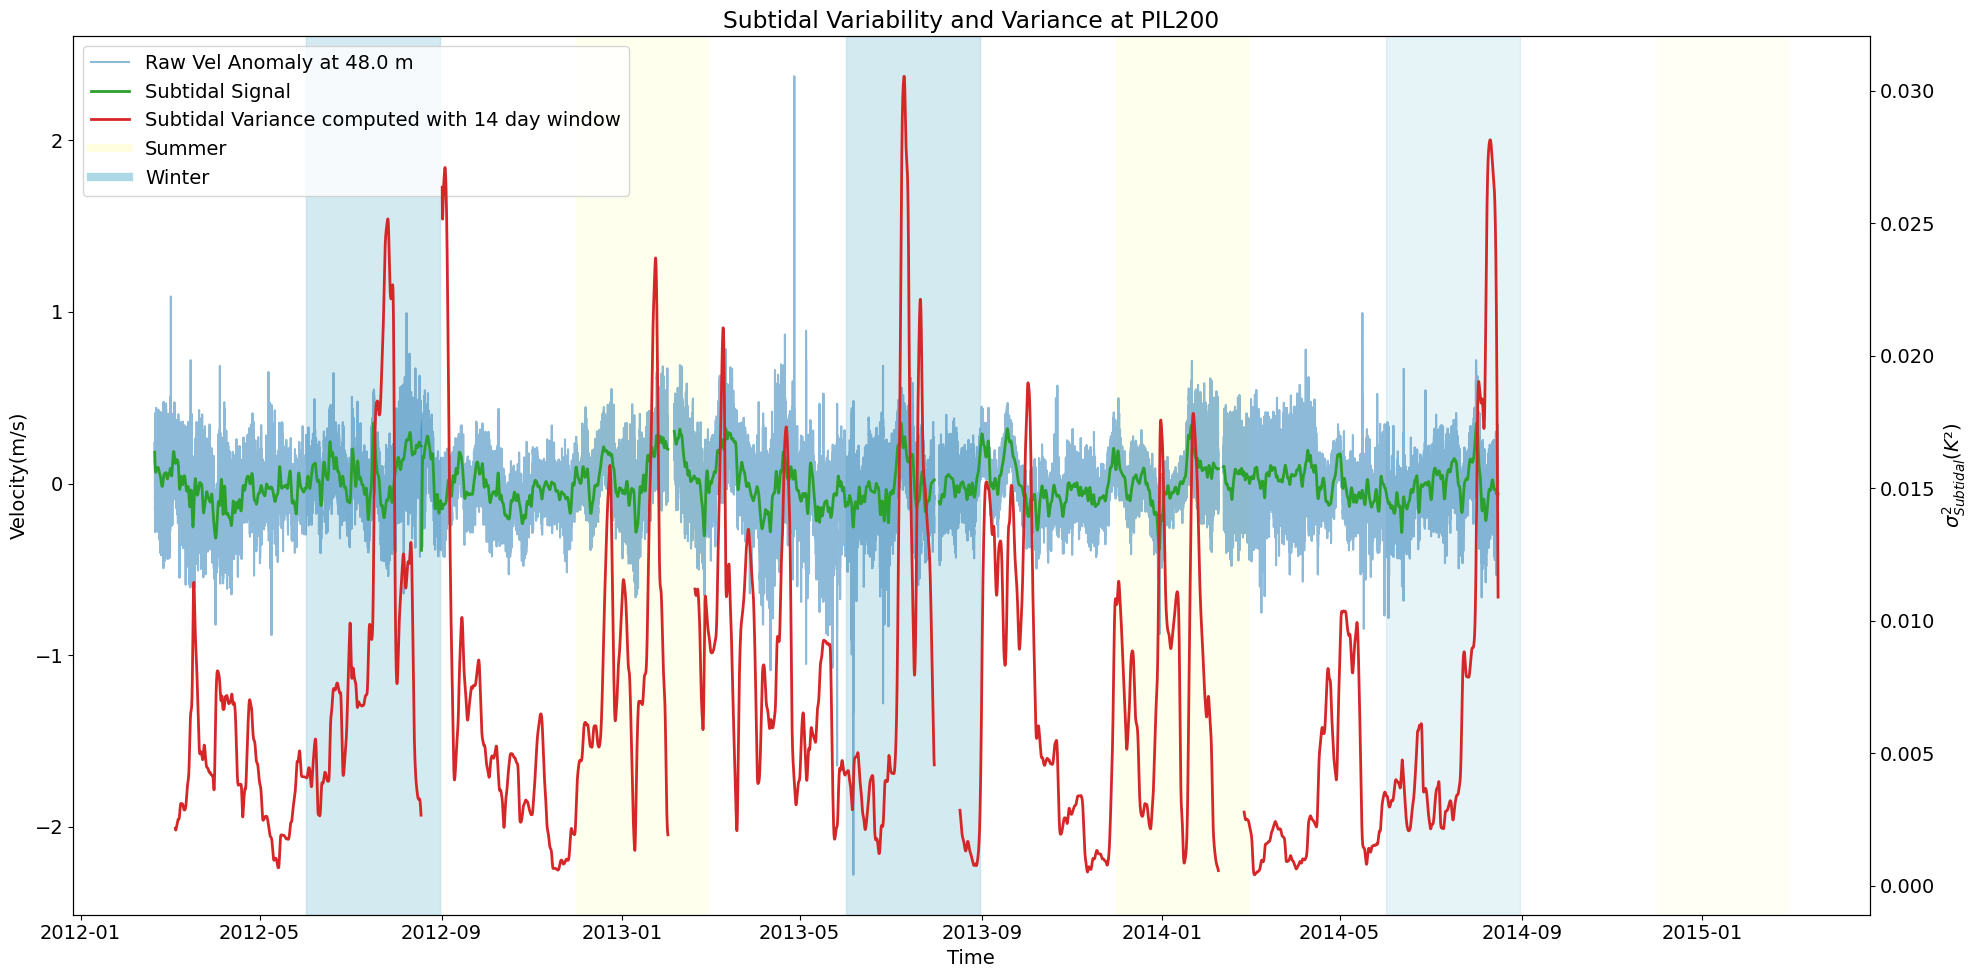

In [94]:
# Example usage
day = 14
example_names = ['PIL200_P0', 'PIL200_P1', 'PIL200_P2', 'PIL200_P3', 'PIL200_P4']
Plot_subtidal_var_single(example_names, Whole_Time_dict, Whole_ϵ_dict, Whole_filtered_ϵ_dict, window_day=day)

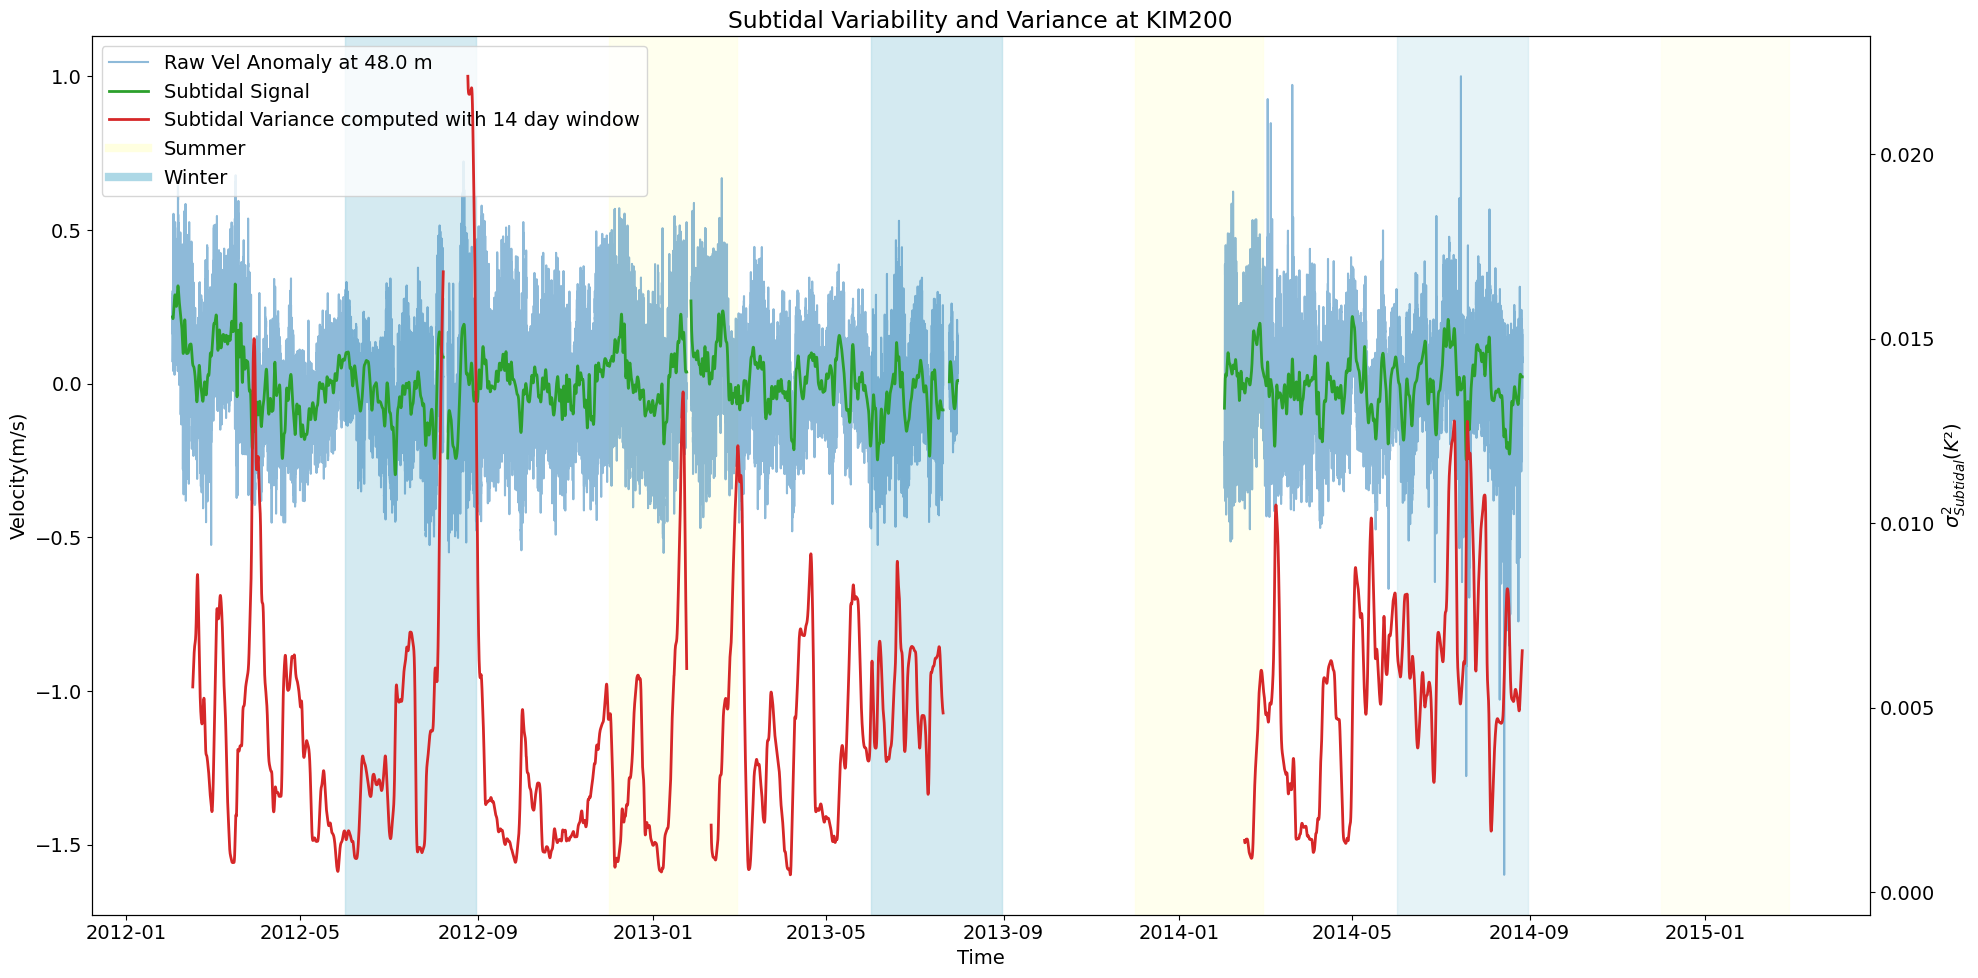

In [95]:
example_names = ['KIM200_P0', 'KIM200_P1', 'KIM200_P2', 'KIM200_P3', 'KIM200_P4']
Plot_subtidal_var_single(example_names, Whole_Time_dict, Whole_ϵ_dict, Whole_filtered_ϵ_dict, window_day=day)

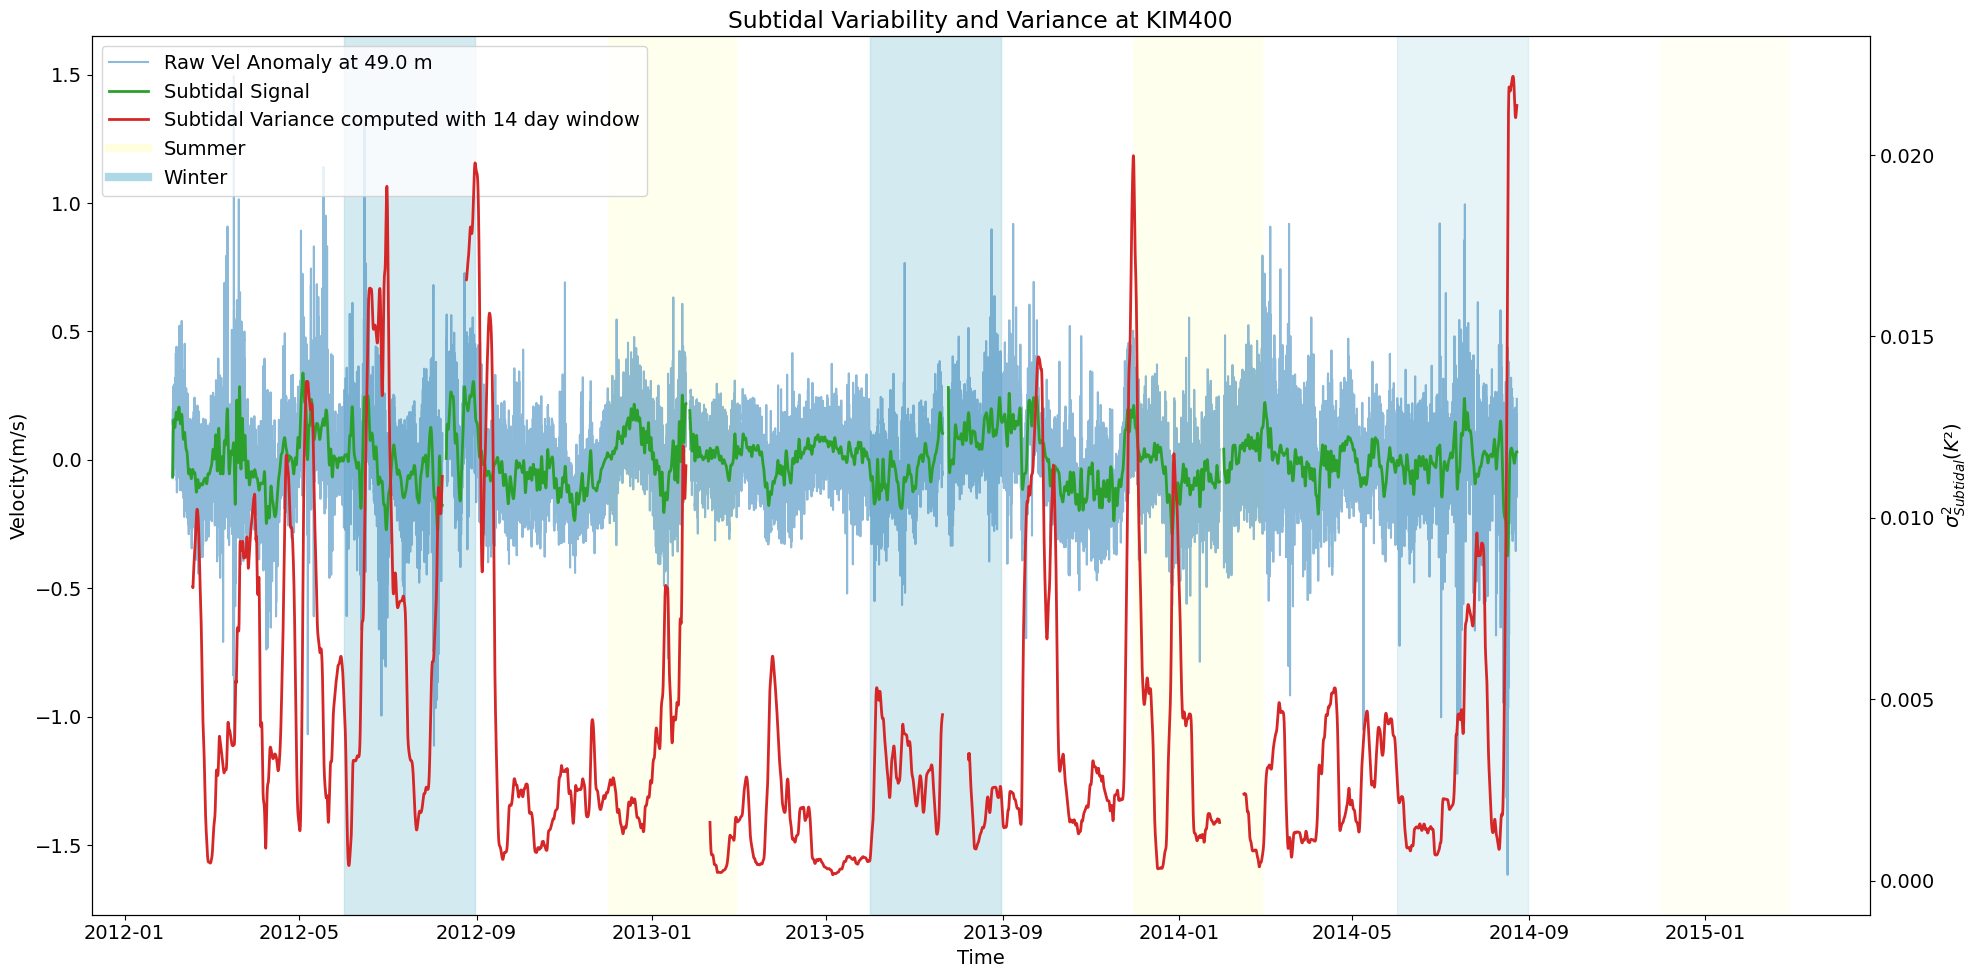

In [96]:
example_names = ['KIM400_P0', 'KIM400_P1', 'KIM400_P2', 'KIM400_P3', 'KIM400_P4']
Plot_subtidal_var_single(example_names, Whole_Time_dict, Whole_ϵ_dict, Whole_filtered_ϵ_dict, window_day=day)

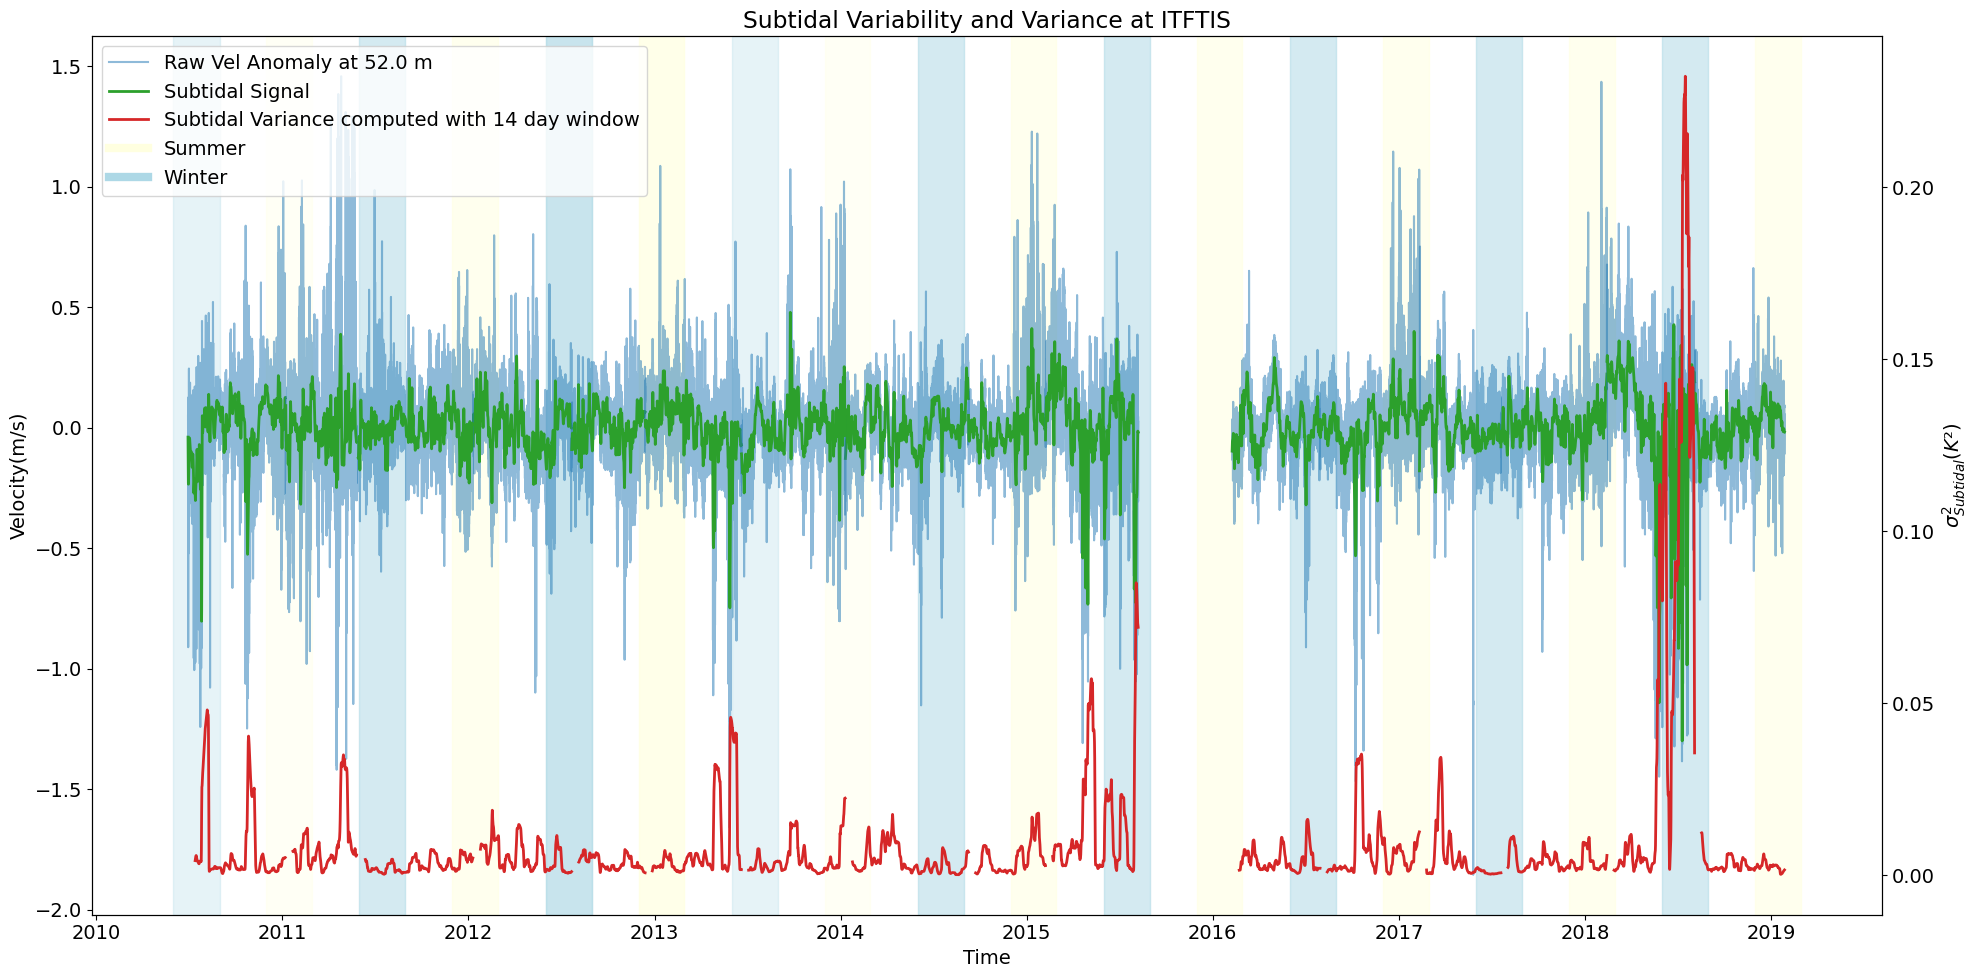

In [98]:
example_names = ['ITFTIS_P0', 'ITFTIS_P1', 'ITFTIS_P2', 'ITFTIS_P3', 'ITFTIS_P4',
                 'ITFTIS_P5', 'ITFTIS_P6', 'ITFTIS_P7', 'ITFTIS_P8', 'ITFTIS_P9',
                 'ITFTIS_P10', 'ITFTIS_P11', 'ITFTIS_P12', 'ITFTIS_P13', 'ITFTIS_P14',
                 'ITFTIS_P15', 'ITFTIS_P16',]
Plot_subtidal_var_single(example_names, Whole_Time_dict, Whole_ϵ_dict, Whole_filtered_ϵ_dict, window_day=day)

In [100]:
def Construct_final_df(time_dict,data_dict,name):
    combined_data = []
    for key in time_dict.keys():
        site_info = key[:6]  # Extract first 6 characters as site info
        t = time_dict[key].values
        d = data_dict[key]
        combined_data.append({"Site": site_info, "Code": key, "start_time": t[0].astype('datetime64[D]'), name: d})
    # Create DataFrame
    df = pd.DataFrame(combined_data) 
    df['adjusted_month'] = df['start_time'].apply(adjust_month)
    return df
    
# Adjust month based on cutoff days
def adjust_month(start_time, cutoff_days=15):
    # Get the last day of the current month
    next_month = (start_time + pd.DateOffset(days=31)).replace(day=1)
    last_day_of_month = next_month - pd.Timedelta(days=1)
    
    # Check if the date is within the cutoff
    if (last_day_of_month - start_time).days <= cutoff_days:
        # Increment the month
        return (start_time + pd.DateOffset(months=1)).month
    else:
        # Return the current month
        return start_time.month

In [ ]:
Whole_ϵ_shallow_dict = {}
Whole_Time_shallow_dict = {}
for i in Whole_ϵ_windowed_dict:
    if Whole_ϵ_windowed_dict[i]['NOMINAL_DEPTH']>150:
        Whole_ϵ_shallow_dict[i]    = Whole_ϵ_windowed_dict[i]
        Whole_Time_shallow_dict[i] = Whole_Time_windowed_dict[i]


#subtidal
cutoff_freq = (f_coriolis_cpd-0.01)/86400 
Whole_filtered_ϵ_dict,\
Whole_filtered_ϵ_var_dict = Cal_Var_from_ϵ(Whole_ϵ_shallow_dict,cutoff_freq)

In [ ]:
#df = Construct_final_df(Whole_Time_windowed_dict,Whole_filtered_ϵ_var_dict,'ϵ_var_subtidal')
df_shallow = Construct_final_df(Whole_Time_shallow_dict,Whole_filtered_ϵ_var_dict,'ϵ_var_subtidal')
# df['HA_var'] = df['Code'].map(Whole_HA_var_dict)
df

In [ ]:
# Group by Site and adjusted_month, then calculate mean and quantiles
grouped = df_shallow.groupby(['Site', 'adjusted_month']).agg({
    'ϵ_var_subtidal': ['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]}).reset_index()
# grouped = df.groupby(['Site', 'adjusted_month']).agg({
#     'HA_var': ['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]}).reset_index()
grouped.columns = ['Site', 'adjusted_month', 'median', 'q25', 'q75']
custom_order1 = ['PIL200','KIM200','KIM400','ITFTIS']
custom_order2 = [2,3,4,5,6,7,8,9,10,11,12,1]
grouped['Site'] = pd.Categorical(grouped['Site'], categories=custom_order1, ordered=True)
grouped['adjusted_month'] = pd.Categorical(grouped['adjusted_month'], categories=custom_order2, ordered=True)
grouped['adjusted_month_num'] = grouped['adjusted_month'].cat.codes  # Convert to numeric codes for plotting

# Sort the DataFrame
grouped = grouped.sort_values(['Site','adjusted_month'])
grouped

In [ ]:
# Now, in your plotting code, use 'adjusted_month_num' for plotting
plt.figure(figsize=(10, 5))
color_set = ['Cyan', 'Purple', 'blue', 'orange']

for i, site in enumerate(grouped['Site'].unique()):
    site_data = grouped[grouped['Site'] == site]
    # Apply a small horizontal offset for each site
    offset = (i - len(grouped['Site'].unique()) / 2) * 0.1  # 0.1 is the offset value
    plt.plot(site_data['adjusted_month_num'] + offset, site_data['median'], color=color_set[i], label=site, linewidth=2)
    for _, row in site_data.iterrows():
        # Add error bars
        plt.errorbar(row['adjusted_month_num'] + offset, row['median'], 
                     yerr=[[row['median'] - row['q25']], [row['q75'] - row['median']]],
                     fmt='o', color=color_set[i], capsize=2)

# Customize plot
plt.xlabel('Month')
plt.xticks(ticks=grouped['adjusted_month_num'].unique(), labels=grouped['adjusted_month'].unique())
plt.ylabel('$σ^{2}_{Subtidal} (K²)$')
plt.legend(title='Site')
plt.tight_layout()

# Show plot
plt.savefig('Subtidal Variance Median.pdf', bbox_inches='tight')